# Simple Speech Recognition
by Jianxi Li


# Exploratory Data Analysis

At first we will begin with data visualization and see the numebr and frequency of the data we are going to study with.

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
#import plotly.tools as tls
import pandas as pd
import librosa
import librosa.display

In [2]:
#First we loaded two different speech of the same word "STOP" 
#and begin to visualize their similarity and difference
file_path1 = 'smallbatch/train/stop/1b835b87_nohash_1.wav'
y,sr= librosa.load(file_path1)

### Let's check the original sampling rate
#### it's 22050hz

In [3]:
sr

22050

In [4]:
file_path11 = 'smallbatch/train/stop/1b835b87_nohash_1.wav'
y11,sr11= librosa.load(file_path1,sr=8000)

In [5]:
sr11

8000

In [6]:
file_path2 = 'smallbatch/train/stop/3ca784ec_nohash_1.wav'
y1,sr1= librosa.load(file_path2,sr=8000)

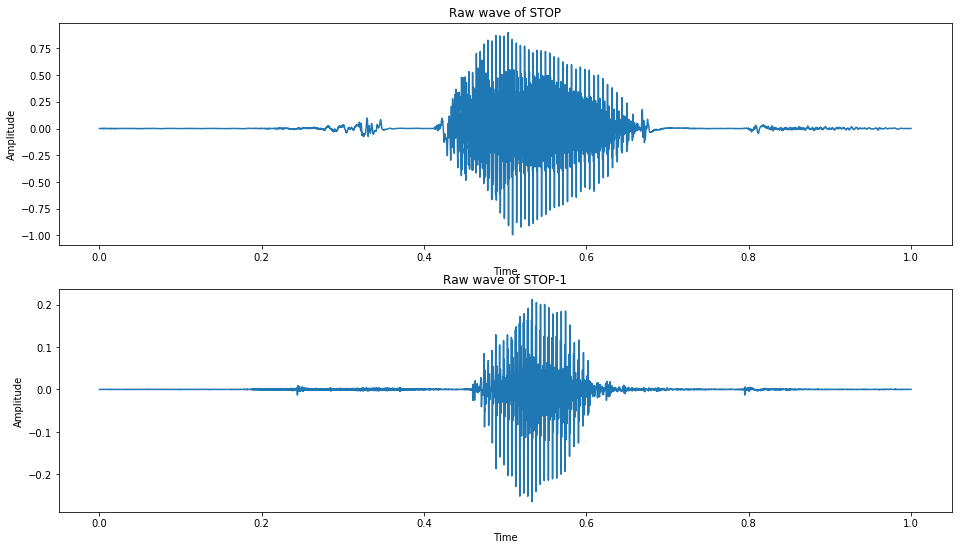

In [7]:
#
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of STOP')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Time')
ax1.plot(np.linspace(0, sr1/len(y1), sr1), y1)
ax2 = fig.add_subplot(212)
ax2.set_title('Raw wave of STOP-1')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time')
ax2.plot(np.linspace(0, sr/len(y), sr), y)
plt.show()

In [8]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

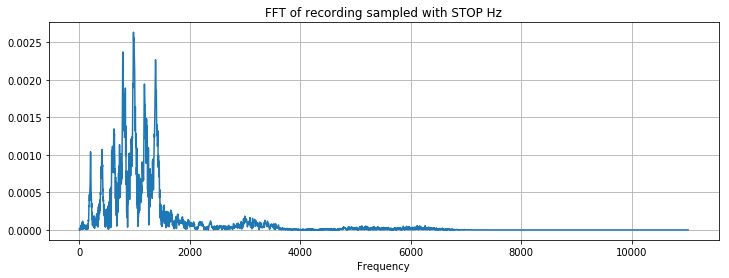

In [9]:
xf, vals = custom_fft(y, sr)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + 'STOP' + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

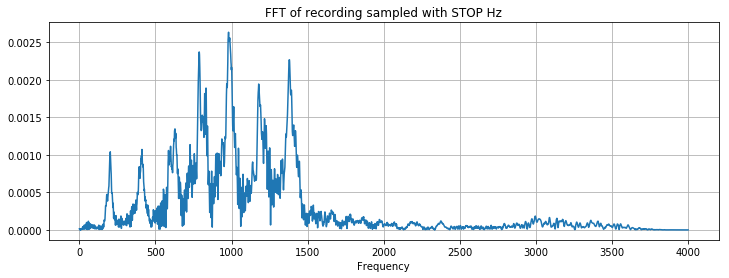

In [10]:
xf, vals = custom_fft(y11, sr11)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + 'STOP' + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

### What it using spectrum to vusualize the .wav file?

In [11]:
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D)

In [12]:
 # Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

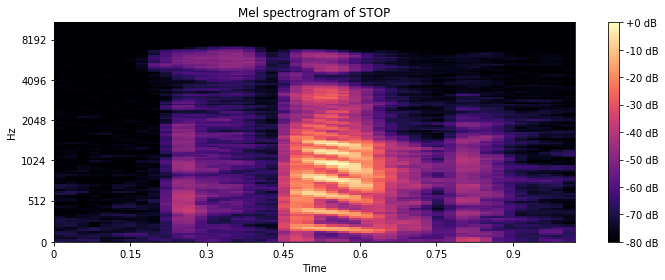

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel',x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram of STOP')
plt.tight_layout()
plt.show()

In [14]:
D1 = np.abs(librosa.stft(y1))**2
S1 = librosa.feature.melspectrogram(S=D1)

In [15]:
 # Passing through arguments to the Mel filters
S1 = librosa.feature.melspectrogram(y=y1, sr=sr, n_mels=256)

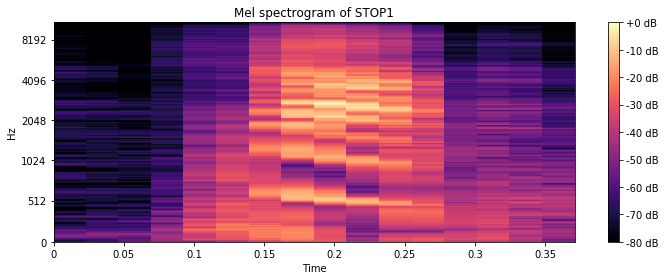

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S1,ref=np.max),y_axis='mel',x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram of STOP1')
plt.tight_layout()
plt.show()

# Now begin to set up the training model

#### this code runs on windows 10 OS with GTX1060, if you are using macbook, it will take a lot of time to train the model
At the very beginning, we could see how many files in the folders

In [17]:
import numpy as np
from keras import backend as K
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import img_to_array

import librosa
import os
import multiprocessing.pool
from functools import partial
from random import getrandbits

train_path='smallbatch/train'
val_path ='smallbatch/val'


#to count how many files inside each class
classnames=os.listdir(train_path)
train_count_dict = {}
for d in classnames:
    train_count_dict[d] = len(os.listdir(os.path.join(train_path, d)))
print('train freq')
for k, v in train_count_dict.items():
    print ( '%7s  %i' % (k, v))
val_count_dict = {}
for d in classnames:
    val_count_dict[d] = len(os.listdir(os.path.join(val_path, d)))
print('\nval freq')
for k, v in val_count_dict.items():
    print ( '%7s  %i' % (k, v))
print ('')
#print ('test files', len(os.listdir(test_path+'/audio')))

C:\Users\Brooks\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


train freq
   down  1906
     go  1917
   left  1900
     no  1914
    off  1883
     on  1906
  right  1894
silence  341
   stop  1919
unknown  2196
     up  1903
    yes  1906

val freq
   down  453
     go  455
   left  453
     no  461
    off  474
     on  461
  right  473
silence  57
   stop  461
unknown  670
     up  472
    yes  471



#### Convert the sound to melspectrogram#
We use function spect_loader extracted from 
(https://github.com/adiyoss/GCommandsPytorch/blob/master/gcommand_loader.py)
to calculate the spectrogram of the audio file;
And the code 'class SpeechDirectoryIterator(Iterator):' is implemented with 

However we decide to use melspectrogram instead of spectrogram since some research 
found that while using MFCC, the performance will better;
So we use a similar chart to MFCC which is mel-spectrogram

In [18]:
def spect_loader(path, window_size, window_stride, window, normalize, max_len=101, 
                 augment=False, allow_speedandpitch=False, allow_pitch=False,
                 allow_speed=False, allow_dyn=False, allow_noise=False,
                allow_timeshift=False ):
    y, sr = librosa.load(path, sr=None)
    #OriginalSampelRate=16Khz;
    # n_fft = 4096
    n_fft = int(sr * window_size)
    win_length = n_fft
    hop_length = int(sr * window_stride)
    
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr,  n_fft = 4096,hop_length=hop_length,n_mels=128)

    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.core.amplitude_to_db(S, ref=np.max)

    
    #made a melspectrogram
    spect=log_S
    
    # make all spects with the same dimentions
    #In case of the mel-spectrogram size different since the lenght of the sound variate
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:max_len, ]
    spect = np.resize(spect, (1, spect.shape[0], spect.shape[1]))
    #spect = torch.FloatTensor(spect)
    
    
    # z-score normalization
    #calculate the mean and standard of the melspect
    if normalize:
        mean = np.mean(np.ravel(spect))
        std = np.std(np.ravel(spect))
        if std != 0:
            spect = spect -mean
            spect = spect / std
    return spect

In [19]:
def _count_valid_files_in_directory(directory, white_list_formats, follow_links):
    """Count files with extension in `white_list_formats` contained in a directory.
    # Arguments
        directory: absolute path to the directory containing files to be counted
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
    # Returns
        the count of files with extension in `white_list_formats` contained in
        the directory.
    """
    def _recursive_list(subpath):
        return sorted(os.walk(subpath, followlinks=follow_links), key=lambda tpl: tpl[0])

    samples = 0
    for root, _, files in _recursive_list(directory):
        for fname in files:
            is_valid = False
            for extension in white_list_formats:
                if fname.lower().endswith('.' + extension):
                    is_valid = True
                    break
            if is_valid:
                samples += 1
    return samples

In [20]:
def _list_valid_filenames_in_directory(directory, white_list_formats,
                                       class_indices, follow_links):
    """List paths of files in `subdir` relative from `directory` whose extensions are in `white_list_formats`.
    # Arguments
        directory: absolute path to a directory containing the files to list.
            The directory name is used as class label and must be a key of `class_indices`.
        white_list_formats: set of strings containing allowed extensions for
            the files to be counted.
        class_indices: dictionary mapping a class name to its index.
    # Returns
        classes: a list of class indices
        filenames: the path of valid files in `directory`, relative from
            `directory`'s parent (e.g., if `directory` is "dataset/class1",
            the filenames will be ["class1/file1.jpg", "class1/file2.jpg", ...]).
    """
    def _recursive_list(subpath):
        return sorted(os.walk(subpath, followlinks=follow_links), key=lambda tpl: tpl[0])

    classes = []
    filenames = []
    subdir = os.path.basename(directory)
    basedir = os.path.dirname(directory)
    for root, _, files in _recursive_list(directory):
        for fname in sorted(files):
            is_valid = False
            for extension in white_list_formats:
                if fname.lower().endswith('.' + extension):
                    is_valid = True
                    break
            if is_valid:
                classes.append(class_indices[subdir])
                # add filename relative to directory
                absolute_path = os.path.join(root, fname)
                filenames.append(os.path.relpath(absolute_path, basedir))
    return classes, filenames

In [21]:
class SpeechDirectoryIterator(Iterator):
    """Iterator capable of reading images from a directory on disk.
    # Arguments
       
    """

    def __init__(self, directory, window_size, window_stride, 
                 window_type, normalize, max_len=101,
                 target_size=(256, 256), color_mode='grayscale',
                 classes=None, class_mode='categorical',
                 batch_size=32, shuffle=True, seed=None,
                 data_format=None, save_to_dir=None,
                 save_prefix='', save_format='png',
                 follow_links=False, interpolation='nearest', augment=False,
                allow_speedandpitch = False, allow_pitch = False,
                allow_speed = False, allow_dyn = False, allow_noise = False, allow_timeshift=False ):
        if data_format is None:
            data_format = K.image_data_format()
        self.window_size = window_size
        self.window_stride = window_stride
        self.window_type = window_type
        self.normalize = normalize
        self.max_len = max_len
        self.directory = directory
        self.allow_speedandpitch = allow_speedandpitch
        self.allow_pitch = allow_pitch
        self.allow_speed = allow_speed 
        self.allow_dyn = allow_dyn
        self.allow_noise = allow_noise
        self.allow_timeshift = allow_timeshift 
        self.augment = augment
#        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        if color_mode not in {'rgb', 'grayscale'}:
            raise ValueError('Invalid color mode:', color_mode,
                             '; expected "rgb" or "grayscale".')
        self.color_mode = color_mode
        self.data_format = data_format
        if self.color_mode == 'rgb':
            #becasue it is rgb, so the hight of the data is 3
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (3,)
            else:
                self.image_shape = (3,) + self.target_size
        else:
            #if it's gray scale, the picture's hight is 1
            if self.data_format == 'channels_last':
                self.image_shape = self.target_size + (1,)
            else:
                self.image_shape = (1,) + self.target_size
        self.classes = classes
        if class_mode not in {'categorical', 'binary', 'sparse',
                              'input', None}:
            raise ValueError('Invalid class_mode:', class_mode,
                             '; expected one of "categorical", '
                             '"binary", "sparse", "input"'
                             ' or None.')
        self.class_mode = class_mode
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        self.interpolation = interpolation

        white_list_formats = {'png', 'jpg', 'jpeg', 'bmp', 'ppm', 'wav'}

        # first, count the number of samples and classes
        self.samples = 0

        if not classes:
            classes = []
            for subdir in sorted(os.listdir(directory)):
                if os.path.isdir(os.path.join(directory, subdir)):
                    classes.append(subdir)
        self.num_classes = len(classes)
        self.class_indices = dict(zip(classes, range(len(classes))))

        pool = multiprocessing.pool.ThreadPool()
        function_partial = partial(_count_valid_files_in_directory,
                                   white_list_formats=white_list_formats,
                                   follow_links=follow_links)
        self.samples = sum(pool.map(function_partial,
                                    (os.path.join(directory, subdir)
                                     for subdir in classes)))

        print('Found %d images belonging to %d classes.' % (self.samples, self.num_classes))

        # second, build an index of the images in the different class subfolders
        results = []

        self.filenames = []
        self.classes = np.zeros((self.samples,), dtype='int32')
        i = 0
        for dirpath in (os.path.join(directory, subdir) for subdir in classes):
            results.append(pool.apply_async(_list_valid_filenames_in_directory,
                                            (dirpath, white_list_formats,
                                             self.class_indices, follow_links)))
            
        
        for res in results:
            classes, filenames = res.get()
            self.classes[i:i + len(classes)] = classes
            self.filenames += filenames
            if i==0:
                #Use the specloader to trans the .wav file to image
                img = spect_loader(os.path.join(self.directory, filenames[0]), 
                               self.window_size, 
                               self.window_stride, 
                               self.window_type, 
                               self.normalize, 
                               self.max_len, 
                               self.augment,
                               self.allow_speedandpitch,
                               self.allow_pitch,
                               self.allow_speed, 
                               self.allow_dyn,
                               self.allow_noise,
                               self.allow_timeshift ) 
                img=np.swapaxes(img, 0, 2)
                self.target_size = tuple((img.shape[0], img.shape[1]))
                print(self.target_size)
                if self.color_mode == 'rgb':
                    if self.data_format == 'channels_last':
                        self.image_shape = self.target_size + (3,)
                    else:
                        self.image_shape = (3,) + self.target_size
                else:
                    if self.data_format == 'channels_last':
                        self.image_shape = self.target_size + (1,)
                    else:
                        self.image_shape = (1,) + self.target_size
                        
            i += len(classes)
        pool.close()
        pool.join()
        super(SpeechDirectoryIterator, self).__init__(self.samples, batch_size, shuffle, seed)
    

    
    
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        batch_f = []
        grayscale = self.color_mode == 'grayscale'
        # build batch of image data
        #print(index_array)
        for i, j in enumerate(index_array):
            #print(i, j, self.filenames[j])
            fname = self.filenames[j]
            #img = load_img(os.path.join(self.directory, fname),
            #               grayscale=grayscale,
            #               target_size=self.target_size,
            #               interpolation=self.interpolation)
            img = spect_loader(os.path.join(self.directory, fname), 
                               self.window_size, 
                               self.window_stride, 
                               self.window_type, 
                               self.normalize, 
                               self.max_len, 
                                )
            img=np.swapaxes(img, 0, 2)
            
            x = img_to_array(img, data_format=self.data_format)
            #x = self.image_data_generator.random_transform(x)
            #x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_f.append(fname)
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=j,
                                                                  hash=np.random.randint(1e7),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(K.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), self.num_classes), dtype=K.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x
        return batch_x, batch_y

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)[0]
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

In [22]:
window_size=.02
window_stride=.01
window_type='hamming'
normalize=True
max_len=101
batch_size = 64
#put the train file to train_iterator
train_iterator = SpeechDirectoryIterator(directory=train_path, 
                                   batch_size=batch_size, 
                                   window_size=window_size, 
                                   window_stride=window_stride, 
                                   window_type=window_type,
                                   normalize=normalize, 
                                   max_len=max_len)

Found 21585 images belonging to 12 classes.
(101, 128)


In [23]:
#put the validation file to val_iterator
val_iterator = SpeechDirectoryIterator(directory=val_path, 
                                   batch_size=batch_size, 
                                   window_size=window_size, 
                                   window_stride=window_stride, 
                                   window_type=window_type,
                                   normalize=normalize, 
                                   max_len=max_len)

Found 5361 images belonging to 12 classes.
(101, 128)


In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#build the training model by keras

#Use model structure similar to the MNIST recognition
#And we have made some optimize of the parameters include the costfunc and optimizer ect.
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=train_iterator.image_shape))
# add a 2d Convolution with 3*3 kernel and 64 output.
model.add(Conv2D(64, (3, 3), activation='relu'))
#Add a maxpooling with 2*2
model.add(MaxPooling2D(pool_size=(2, 2)))
#with 0.25 margin to Dropout 
model.add(Dropout(0.5))
#flat all the pixel
model.add(Flatten())
#use fully connected and the activation is relu
model.add(Dense(128, activation='relu'))
#with 0.5 margin drop out
model.add(Dropout(0.5))
#use the softmax as the activation function
model.add(Dense(len(classnames), activation = 'softmax')) #Last layer with one output per class

#Use crossEntropy as the loss function 
#And set the optimizer as Adadelta
model.compile(loss='categorical_crossentropy', optimizer='Adadelta',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 99, 126, 32)       320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 124, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 62, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 190464)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24379520  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

You could see the detail parameter on the summary

### You could use some functions to automatically change the Learning Rate and stop when the loss do not contibue with a certain steps;

for example, you could use EarlyStopping, ReduceLROnPlateau from Keras API

In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Use this func to early stop when the val_loss do not lower
#Use this ReduceLROnPlateau to auto adapt the LearningRate
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_lr=0.00001)
model.fit_generator(train_iterator,
        steps_per_epoch=int(np.ceil(train_iterator.n / batch_size)),
        epochs=20,
        validation_data=val_iterator,
        validation_steps=int(np.ceil(val_iterator.n / batch_size)),
        verbose=1, callbacks=[early, reduce])

Epoch 1/20
338/338 [==============================] - 499s 1s/step - loss: 1.9517 - acc: 0.3260 - val_loss: 1.4568 - val_acc: 0.5271
Epoch 2/20
338/338 [==============================] - 399s 1s/step - loss: 1.3789 - acc: 0.5224 - val_loss: 1.1444 - val_acc: 0.6439
Epoch 3/20
338/338 [==============================] - 400s 1s/step - loss: 1.0848 - acc: 0.6279 - val_loss: 0.9838 - val_acc: 0.7045
Epoch 4/20
338/338 [==============================] - 399s 1s/step - loss: 0.9053 - acc: 0.6853 - val_loss: 0.9431 - val_acc: 0.7133
Epoch 5/20
338/338 [==============================] - 400s 1s/step - loss: 0.7791 - acc: 0.7257 - val_loss: 0.8984 - val_acc: 0.7288
Epoch 6/20
338/338 [==============================] - 399s 1s/step - loss: 0.6795 - acc: 0.7631 - val_loss: 0.8727 - val_acc: 0.7299
Epoch 7/20
338/338 [==============================] - 399s 1s/step - loss: 0.6014 - acc: 0.7909 - val_loss: 0.9487 - val_acc: 0.7183
Epoch 8/20
338/338 [==============================] - 402s 1s/step - 

## Here is my result of this research 
The final validataion accuracy after 11 epoches is 75.69%